In [1]:
# TODO : ORTHOGONAL INIT OF WEIGHTS. use init_ops.orthogonal

# An implementation of Unrolled Generative Adversarial Networks:
https://arxiv.org/abs/1611.02163, Luke Metz et al.

In [2]:
from __future__ import print_function
import os
import numpy as np
import tensorflow as tf
import time

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.contrib.layers as lyr
from tensorflow.python.ops import init_ops

## Generate dataset

Let's generate a dataset of 2-dimensional datapoints drawn from a gaussian mixture model of 8 gaussians, as in the original paper. 
The centers of the 8 gaussians are equally spaced on 0-centered radius-2 circle in the 2-dimensional space and which variances are 0.05, covariances 0.

In [3]:
angles = [2 * i * np.pi / 8 for i in range(8)]

def get_center(angle, radius=2.):
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    return np.array([x, y])

means = np.zeros((8, 2))
for i in range(8):
    means[i] = get_center(angles[i])

def sample_from_gmm(num_samples):
    # draw which gaussian samples belong to
    belong_to = np.random.randint(0, 8, size=num_samples)
    unique, counts = np.unique(belong_to, return_counts=True)
    
    samples_list = [
        np.concatenate((np.random.normal(means[i, 0], 0.05, size=(counts[i], 1)),
                        np.random.normal(means[i, 1], 0.05, size=(counts[i], 1))), axis=1)
        for i in range(8)
    ]
    samples = np.concatenate((samples_list), axis=0)
    np.random.shuffle(samples)
    return samples

In [4]:
# let's create a dataset with 10000 elements
num_examples = 10000
X_train = sample_from_gmm(num_examples)

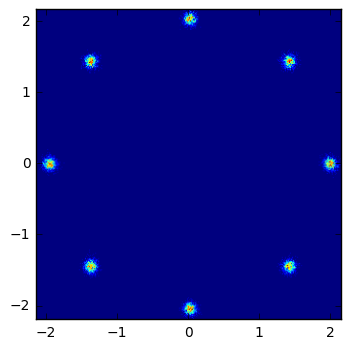

In [5]:
# let's check the distribution of the data
heatmap, xedges, yedges = np.histogram2d(X_train[:, 0], X_train[:, 1], bins=300)
extent_tr = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap, extent=extent_tr, origin='lower')
plt.show()

#plt.savefig('train_gm8.png', bbox_inches='tight')

## Model definition

with a generative adversarial network we optimize the value function V(G, D), successively in G parameters and D parameters. 

$$ \mathbb E_{\mathbf x \sim p_{data}(\mathbf x)}[\log D(\mathbf x)] 
+ \mathbb E_{\mathbf x \sim p_{z}(\mathbf z)}[\log (1 - D(G(\mathbf z))] 
$$

* For an optimization step on G, we perform gradient __descent__ on value function V. 
* For an optimization step on D, we perform gradient __ascent__ on value funtion V. 

In _unrolled GANs_ this is the same, except the D used in G cost is not the current D but the FUTURE version of D. In other words, the graph expression of D after k steps optimization. Everything must be done in the TF graph!

In [7]:
# SOME PARAMETERS FOR ARCHITECTURE AND TRAINING

SEED_DIM = 3
BATCH = 128
train_epochs = 1000
display_step = 500
video_step = 500
make_video = True
unroll_steps = 1
ortho_init=False # strangely, does not seem to help...

In [8]:
tf.reset_default_graph()
if 'session' in globals():
    session.close()

In [9]:
# instead of using tensorflow's built-in optimizers, 
# re-write 'symbolic' adam that can only returns expression of updates

def create_adam_vars(vars):
    # initialize variables needed for an adam optimizer
    adam_vars = {}
    adam_vars['b1_t'] = tf.Variable(1., dtype=tf.float32, name='beta1_pow_t')
    adam_vars['b2_t'] = tf.Variable(1., dtype=tf.float32, name='beta2_pow_t')
    for key in vars.keys():
        mname = '%s%s' %('mom_', key)
        vname = '%s%s' %('vel_', key)
        adam_vars[mname] = tf.Variable(tf.zeros(tf.shape(vars[key])))
        adam_vars[vname] = tf.Variable(tf.zeros(tf.shape(vars[key])))
    return adam_vars

# TODO: 
# * optimise order / number of computations
# * see why slower than base tf opt ?
def adam_updates(cost, vars, adam_vars, lr=1e-4, beta1=0.5, beta2=0.999, epsilon=1e-8):
    # return symbolic expression of vars_updates and and adam_vars_updates
    vars_upd = {}
    adam_vars_upd = {}
    adam_vars_upd['mom'] = {}
    adam_vars_upd['vel'] = {}

    b1_t_new = adam_vars['b1_t'] * beta1
    b2_t_new = adam_vars['b2_t'] * beta2

    # faster of we call gradients on a list ?
    for key, var in vars.items():
        grad = tf.gradients(cost, var)[0]
        mname = '%s%s' %('mom_', key)
        vname = '%s%s' %('vel_', key)
        mom_new = tf.mul(beta1, adam_vars[mname]) + tf.mul((1. - beta1), grad)
        vel_new = tf.mul(beta2, adam_vars[vname]) + tf.mul((1. - beta2), tf.pow(grad, 2))
        lr_t = tf.mul(lr, tf.div(tf.sqrt(1. - b2_t_new), 1. - b1_t_new))
        # make sure vel_new is positive
        vel_new = tf.maximum(vel_new, 1e-14)
        var_new = var - tf.div(tf.mul(lr_t, mom_new), tf.sqrt(vel_new) + epsilon)

        adam_vars_upd[mname] = mom_new
        adam_vars_upd[vname] = vel_new
        vars_upd[key] = var_new

    adam_vars_upd['b1_t'] = b1_t_new
    adam_vars_upd['b2_t'] = b2_t_new

    return vars_upd, adam_vars_upd

def check_numerics_dic(vars, message, name=None):
    vars_checked = {}
    for key, var in vars.items():
        var_new = tf.check_numerics(var, message, name)
        vars_checked[key] = var_new
    return vars_checked

In [10]:
# define generator and dicriminator networks
# in order to allow unroll, they do not have associated variables, but take them also as input

# G architecture
# in_z: (BATCH, SEED_DIM)
# --- W0: (SEED_DIM, 128); b0: (128)
# g0: (BATCH, 128)
# --- W1: (128, 128); b1: (128)
# g1: (BATCH, 128)
# --- W2: (128, 2); b2: (2)
# g2: (BATCH, 2)

def xav_range(in_dim, out_dim):
    # xavier range for normal init
    return np.sqrt(3. / (in_dim + out_dim))

def fc_vars(name, in_dim, out_dim, ortho):
    W_name = '%s%s' % ('W_', name)
    if not ortho:
        W = tf.Variable(tf.random_normal([in_dim, out_dim], 
                                         stddev=xav_range(in_dim, out_dim)), 
                                         name=W_name)
    # it appears that orthogonal init helps: (requires tf 0.12)
    else:
        W = tf.get_variable(W_name, 
                            shape=[in_dim, out_dim], 
                            initializer=tf.orthogonal_initializer(gain=xav_range(in_dim, out_dim)))
    b_name = '%s%s' % ('b_', name)
    b = tf.Variable(tf.zeros([out_dim]), 
                             name=b_name)
    return {W_name: W, b_name: b,}

def create_vars_g(ortho):
    vars = {}
    vars.update(fc_vars('g0', SEED_DIM, 128, ortho))
    vars.update(fc_vars('g1', 128, 128, ortho))
    vars.update(fc_vars('g2', 128, 2, ortho))
    return vars

def create_vars_d(ortho):
    vars = {}
    vars.update(fc_vars('d0', 2, 128, ortho))
    #vars.update(fc_vars('d00', 128, 128, ortho))
    vars.update(fc_vars('d1', 128, 1, ortho))
    return vars

def generator(in_z, vars_g):
    g0 = tf.nn.relu(tf.matmul(in_z, vars_g['W_g0']) + vars_g['b_g0'])
    g1 = tf.nn.relu(tf.matmul(g0, vars_g['W_g1']) + vars_g['b_g1'])
    g2 = tf.matmul(g1, vars_g['W_g2']) + vars_g['b_g2'] # linear
    return g2

def discriminator(in_x, vars_d):
    d0 = tf.nn.relu(tf.matmul(in_x, vars_d['W_d0']) + vars_d['b_d0'])
    #d0 = tf.nn.relu(tf.matmul(d0, vars_d['W_d00']) + vars_d['b_d00'])
    d1 = tf.sigmoid(tf.matmul(d0, vars_d['W_d1']) + vars_d['b_d1'])
    return d1

In [11]:
# --------------------------
# define placeholders
# --------------------------
z_rand = tf.placeholder(tf.float32, (BATCH, SEED_DIM,))
x_data = tf.placeholder(tf.float32, (BATCH, 2))

# --------------------------
# Create variables for G, D, and their optimizers
# --------------------------
vars_g = create_vars_g(ortho=ortho_init)
vars_d = create_vars_d(ortho=ortho_init)
adam_vars_g = create_adam_vars(vars_g)
adam_vars_d = create_adam_vars(vars_d)

# for D:
X_GENERATED = generator(z_rand, vars_g)
P_RAND_REAL = discriminator(X_GENERATED, vars_d)
P_DATA_REAL = discriminator(x_data, vars_d)
VALFUNC_D = tf.reduce_mean(tf.log(1e-6 + P_DATA_REAL) 
                           + tf.log(1e-6 + 1. - P_RAND_REAL))
vars_upd_d, adam_vars_upd_d = adam_updates(-VALFUNC_D, vars_d, adam_vars_d)
vars_upd_d = check_numerics_dic(vars_upd_d, "VARS_UPD_D NUMERICS")

op_d = tf.group(*([tf.assign(vars_d[key], vars_upd_d[key]) 
                   for key in vars_d.keys()] 
                + [tf.assign(adam_vars_d[key], adam_vars_upd_d[key]) 
                   for key in adam_vars_d.keys()]))

# for G
x_generated = generator(z_rand, vars_g)
# --- unroll steps -------------------
vars_upd_du, adam_vars_upd_du = vars_d, adam_vars_d
for i in range(unroll_steps):
    p_rand_real = discriminator(x_generated, vars_upd_du)
    p_data_real = discriminator(x_data, vars_upd_du)
    valfunc_du = tf.reduce_mean(tf.log(1e-6 + p_data_real) 
                               + tf.log(1e-6 + 1. - p_rand_real))
    vars_upd_du, adam_vars_upd_du = adam_updates(
        -valfunc_du, vars_upd_du, adam_vars_upd_du)
    vars_upd_du = check_numerics_dic(
        vars_upd_du, "VARS_UPD_DU NUMERICS", name='check_du')
# ------------------------------------

p_rand_realu = discriminator(x_generated, vars_upd_du)
p_rand_realu = tf.check_numerics(p_rand_realu, "P_RAND_REALU NUMERICS", name='check_prealu')

valfunc_g = tf.reduce_mean(tf.log(1e-6 + 1. - p_rand_realu))
valfunc_g = tf.check_numerics(valfunc_g, "VALFUNC_G NUMERICS", name='check_valfg')

vars_upd_g, adam_vars_upd_g = adam_updates(valfunc_g, vars_g, adam_vars_g)
vars_upd_g = check_numerics_dic(vars_upd_g, "VARS_UPD_G NUMERICS", name='check_vars_updg')

op_g = tf.group(*([tf.assign(vars_g[key], vars_upd_g[key]) 
                   for key in vars_g.keys()]
                + [tf.assign(adam_vars_g[key], adam_vars_upd_g[key]) 
                   for key in adam_vars_g.keys()]))

In [12]:
# Session and initializations
session = tf.Session()

def init_dict_vars(dic):
    init_list = [tf.initialize_variables([v]) for v in dic.values()]
    op = tf.group(*init_list)
    return op

init_op_nets = tf.group(*[init_dict_vars(dic) for dic in [vars_g, vars_d]])
init_op_optim = tf.group(*[init_dict_vars(dic) for dic in [adam_vars_g, adam_vars_d]])

# INITIALIZE FIRST NETWORK VARS; THEN ADAM VARS. BECAUSE ADAM DEPEND ON NET VARS. 

session.run(init_op_nets)
session.run(init_op_optim)

Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Use `tf.variables_initializer` inst

### Some helper funtions

In [13]:
def train_d(numeric_in):
    _, valfunc_d_value = session.run([op_d, VALFUNC_D], feed_dict={
            z_rand: numeric_in['z_rand'], 
            x_data: numeric_in['x_data'],})
    return valfunc_d_value

def train_g(numeric_in):
    _, valfunc_g_value = session.run([op_g, valfunc_g], feed_dict={
            z_rand: numeric_in['z_rand'], 
            x_data: numeric_in['x_data'],})
    return valfunc_g_value

def generate(numeric_in):
    x_generated_value = session.run(x_generated, feed_dict={
            z_rand: numeric_in['z_rand'],})
    return x_generated_value

In [14]:
# for plotting results

def get_frame(n_example=5000):
    num_gen_examples = (n_example / BATCH) * BATCH
    x_generated_values = np.zeros((num_gen_examples, 2))
    
    for batch_idx in range(num_gen_examples / BATCH):
        numeric_in = dict(
            z_rand = np.random.normal(size=(BATCH, SEED_DIM)).astype(np.float32),)
        x_generated_batch = generate(numeric_in)
        x_generated_values[batch_idx * BATCH: (batch_idx+1) * BATCH] = x_generated_batch
        
    heatmap, _, _ = np.histogram2d(x_generated_values[:, 0], 
                                   x_generated_values[:, 1], bins=300)
    
    return heatmap

In [15]:
# with unroll, train several hundred thousand steps. 

step = 0
t_begin = time.time()
frames = [] # for the training video
try:
    for ep in range(train_epochs):
        for batch_idx in range(num_examples / (2 * BATCH)):
            # for each epoch half of the examples are used for G, half for D
            numeric_in_d = dict(
                z_rand = np.random.normal(size=(BATCH, SEED_DIM)).astype(np.float32),
                x_data = X_train[2* batch_idx * BATCH: (2 * batch_idx + 1) * BATCH],)
            numeric_in_g = dict(
                z_rand = np.random.normal(size=(BATCH, SEED_DIM)).astype(np.float32),
                x_data = X_train[(2 * batch_idx + 1) * BATCH: (2 * batch_idx + 2) * BATCH],)
            
            valfunc_d_value = train_d(numeric_in_d)
            valfunc_g_value = train_g(numeric_in_g)
            step += 1
            if step % display_step == 0:
                print("trained %d steps G and as many D, %d total" %(step, step * 2))
                print("g valfunc: " + str(valfunc_g_value))
                print("d valfunc: " + str(valfunc_d_value))
            if step % video_step == 0 and make_video:
                frames += [get_frame(n_example=5000)]
except KeyboardInterrupt:
    print("Interrupted")
    
print("training time: " + str(time.time() - t_begin))

trained 500 steps G and as many D, 1000 total
g valfunc: -0.649288
d valfunc: -1.3783
trained 1000 steps G and as many D, 2000 total
g valfunc: -0.674909
d valfunc: -1.36405
trained 1500 steps G and as many D, 3000 total
g valfunc: -0.683957
d valfunc: -1.36277
trained 2000 steps G and as many D, 4000 total
g valfunc: -0.682452
d valfunc: -1.36434
trained 2500 steps G and as many D, 5000 total
g valfunc: -0.680578
d valfunc: -1.36059
trained 3000 steps G and as many D, 6000 total
g valfunc: -0.682054
d valfunc: -1.35584
trained 3500 steps G and as many D, 7000 total
g valfunc: -0.680002
d valfunc: -1.35803
trained 4000 steps G and as many D, 8000 total
g valfunc: -0.680294
d valfunc: -1.3606
trained 4500 steps G and as many D, 9000 total
g valfunc: -0.676752
d valfunc: -1.35818
trained 5000 steps G and as many D, 10000 total
g valfunc: -0.678609
d valfunc: -1.35728
trained 5500 steps G and as many D, 11000 total
g valfunc: -0.680108
d valfunc: -1.3566
trained 6000 steps G and as many D

## Generate samples and plot their distribution

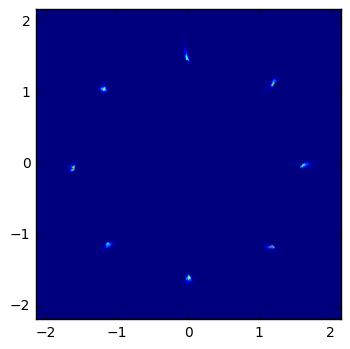

array([[ 1.44833624,  1.49608684],
       [-1.41755664,  1.37286651],
       [ 1.36579478, -1.55222309],
       ..., 
       [ 1.541623  ,  1.51132536],
       [ 1.52959442,  1.52269101],
       [ 1.52652729,  1.48417294]])

In [16]:
num_gen_examples = 5000
# round to an entire multiple of BATCH
num_gen_examples = (num_gen_examples / BATCH ) * BATCH
x_generated_values = np.zeros((num_gen_examples, 2))

for batch_idx in range(num_gen_examples / BATCH):
    numeric_in = dict(
        z_rand = np.random.normal(size=(BATCH, SEED_DIM)).astype(np.float32),)
    x_generated_batch = generate(numeric_in)
    x_generated_values[batch_idx * BATCH: (batch_idx+1) * BATCH] = x_generated_batch


heatmap, xedges, yedges = np.histogram2d(x_generated_values[:, 0], 
                                         x_generated_values[:, 1], bins=300)

plt.clf()
plt.imshow(heatmap, extent=extent_tr, origin='lower')
plt.show()

x_generated_values

In [17]:
# Save frames
np.save("frames", np.asarray(frames))
np.save("extent_tr", np.asarray(extent_tr))

# then make movie with make_video.ipynb

In [18]:
# create a movie from frames
# HP setting: seed 3, 2 layers, already a great difference between 0 and 1 unroll

In [19]:
# just include mp4 in html with:
#<video controls="" data-flashblockwhitelisted="true" width="720">
#<source src="/video/film-2010-06.mp4" type="video/mp4"></source>
#**Votre navigateur ne supporte pas la balise *video*. Merci d'utiliser un
#navigateur respectueux des standards ([Firefox](\"http://mozilla.org/firefox/\")
#par exemple)**
#</video>

# or try responsibe embed:
# http://getbootstrap.com/components/#responsive-embed

In [20]:
len(frames)

234

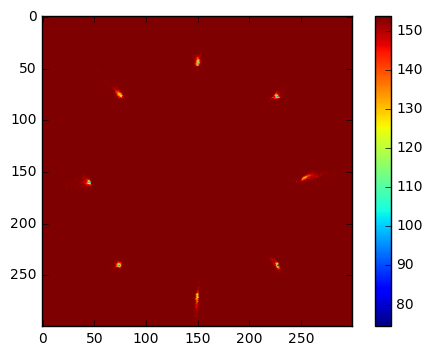

In [22]:
plt.clf()
fig = plt.figure()
# change scale
frame_num = -1
frame_plot = (128. - frames[frame_num])*1.2
plt.imshow(frame_plot)#, cmap='hot')#, clim=(0., 128.))
plt.colorbar()